# Introduction
learn how to generate graphs given examples. 

Graphlearn has a fit and a sample stage. 
1. Fit: given graphs, train an estimator, collect graph fragments.
2. Sample: given initial graphs, optimize by exchanging random fragments and scoring via the estimator.

The graph fragments are organized in a grammar that groups interchangeable (congruent) subgraphs.
The estimator is either a one or two class estimator. The Sampling process is adjustable, it might ensemble
MCMC sampling, simulated annealing or just straight greedy improvement of graphs.

See the last Notebook of this introduction for more details about the sampling process.

### Ipython Notebook init

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1) # use 2 for more info
BABELDRAW=False

# Fitting a sampler


### Graph formats

The sampler expects networkx graphs. Overview on supported graph formats:
https://networkx.github.io/documentation/networkx-1.10/reference/readwrite.html.
The eden package, that is required to run graphlearn, supports additional formats.

We define get_graphs which will return an iterable over networkx graphs.



### Fitting options

##### sampler init:
We see the default options for learning the grammar.
these are not very optimized.

You may provide a feasibility_checker that aproves all 
generated graphs. To exclude single nodes from the grammar, rendering them unchangeable, the node_entity_checker is interesting.

##### fitting:
Here a oneclass estimator will be used.
You might also provide a second set of graphs
or give a pretrained estimator in sampler init.

In [2]:
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

dataset_fname = 'toolsdata/bursi.pos.gspan'

In [3]:
%%time
from graphlearn.graphlearn import  Sampler

sampler=Sampler(radius_list=[0,1], 
                thickness_list=[1,2],
                min_cip_count=2, 
                min_interface_count=2)
sampler.fit(get_graphs(dataset_fname, size=200))


# lets look at a few stats about the trained sampler
print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

# dumps the sampler for later use. This is not mandatory :) 
sampler.save('tmp/sampler.ge')

graph grammar stats:
#instances: 200   #interfaces: 155   #cores: 74   #core-interface-pairs: 627
CPU times: user 6.22 s, sys: 504 ms, total: 6.72 s
Wall time: 11.1 s


# Grammar Inspection

If you are interested in the generated grammar, there are 
two useful tools available. 
You can draw the grammar directly, as seen below.
draw_grammar_stats will collect statistics about the grammar and visualize them nicely.

interface id: 540114 [28 options]


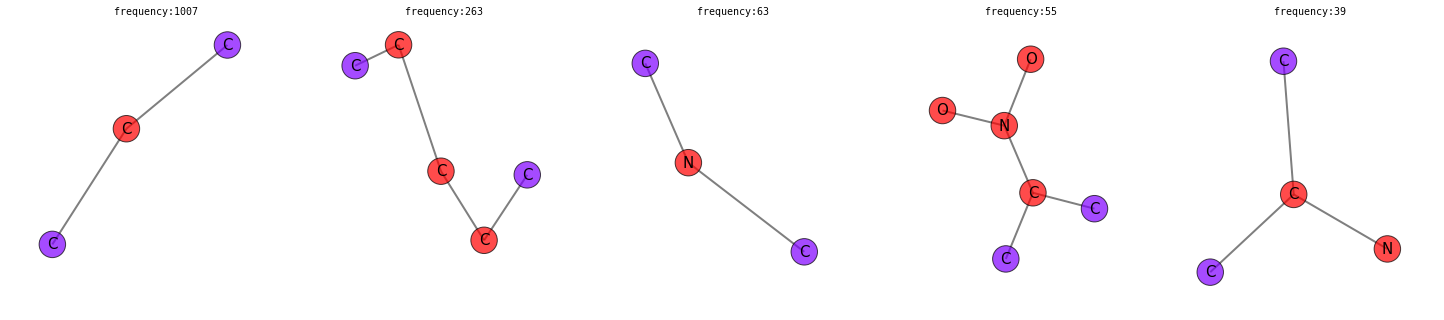

In [4]:
from graphlearn.utils.draw import draw_grammar
# draw one group of graph fragments (CIPS)
draw_grammar(sampler.grammar().productions, contract=True,
             n_productions=1,
             n_graphs_per_line=5,
             n_graphs_per_production=5,
             size=5, 
             colormap='rainbow', 
             node_border=1, 
             vertex_alpha=0.7, 
             edge_alpha=0.5, 
             node_size=700)
#from graphlearn.utils.draw import draw_grammar_stats
#draw_grammar_stats(sampler.lsgg.productions, size=(10,5))

# Sample

Sampling with default options will work just fine if you are just interested
in new graphs. The n_steps parameter defines 
how many attempts of altering a graph are made.

##### Options that will influence the acceptance of a generated graph:

In each sampling step, a graph is altered and scored.
An accept function decides if we keep the new graph. The parameters listed here 
influence this acceptance function.

improving_threshold=.5,
after this fraction of steps, only improvements are accepted  ---
improving_linear_start=0.0, 
graphs are accepted with a probability depending on their score. From this fraction it becomes gradually harder for worse graphs to be accepted. ---
accept_static_penalty=0.0, 
graphs that are worse than their predecessors get this penalty (on top of the other two options).

##### Options for choosing the new fragment:

The fragment chosen for alteration can be influenced by the acceptable node parameter (see sampler init). 
In general it will be chosen randomly. The fragment it will be replaced with can be influenced however:

probabilistic_core_choice=False, with this option we choose the fragment according to its frequency in the grammar.  ---
score_core_choice= True, choose the fragment according to score ( given by estimator ), the better the score, the more likely it is for a fragment to be picked ---
max_size_diff=1, maximum size difference between the seed graph and every graph generated graph. if choosing a fragment will violate the 
size constraints, it will not be selected.

#####  Output multiple graphs (along the sample path):


burnin=10, ignore the first burnin graphs for the nsamples parameter ---
n_samples=n_samples, from burnin to end of sample, collect this many samples. ---
keep_duplicates=True, duplicates may be deleted ---
include_seed=True,  seed will be the first graph in the output list. 

##### Collect additional information during sampling, that may help debugging

monitor=True, after sampling acessible via eg sampler.monitors[1][9] (first graph, ninth step)
                        
##### Output format 
sample() will yield a list of graph for each input graph.

In [5]:
%%time
from itertools import islice
from graphlearn.graphlearn import  Sampler
sampler=Sampler()
sampler.load('tmp/sampler.ge')

# picking graphs
graphs = get_graphs(dataset_fname, size=100)
id_start=50
id_end=id_start+6
input_graphs = islice(graphs,id_start,id_end)

# sample parameters
n_steps=60 # how many steps
n_samples=4 # collect this many samples during the process

graphs = sampler.sample(input_graphs,
                        n_steps=n_steps, n_samples=n_samples,
                        target_orig_cip=False,
                        probabilistic_core_choice=False,
                        score_core_choice= False,
                        max_size_diff=1,
                        burnin=10,
                        include_seed=True,
                        proposal_probability = False,
                        improving_threshold=.5, 
                        improving_linear_start=0.0,
                        accept_static_penalty=0.0,
                        n_jobs=1,
                        select_cip_max_tries=200,
                        keep_duplicates=True,  
                        monitor=True)

CPU times: user 248 ms, sys: 28 ms, total: 276 ms
Wall time: 279 ms


Graph id: 50


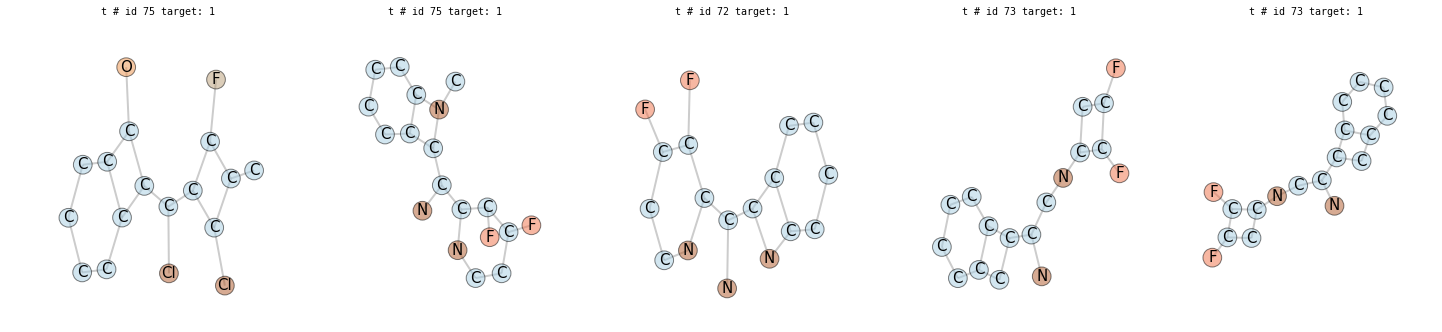

Graph id: 51


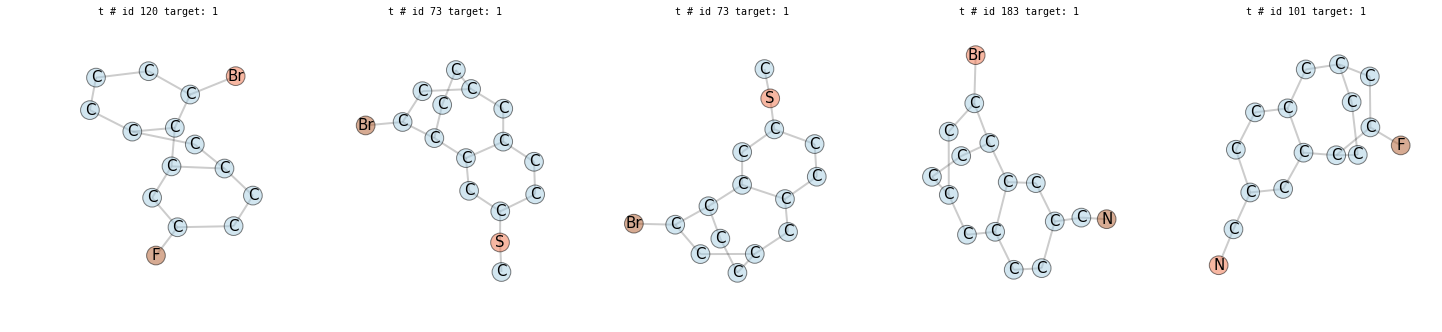

Graph id: 52


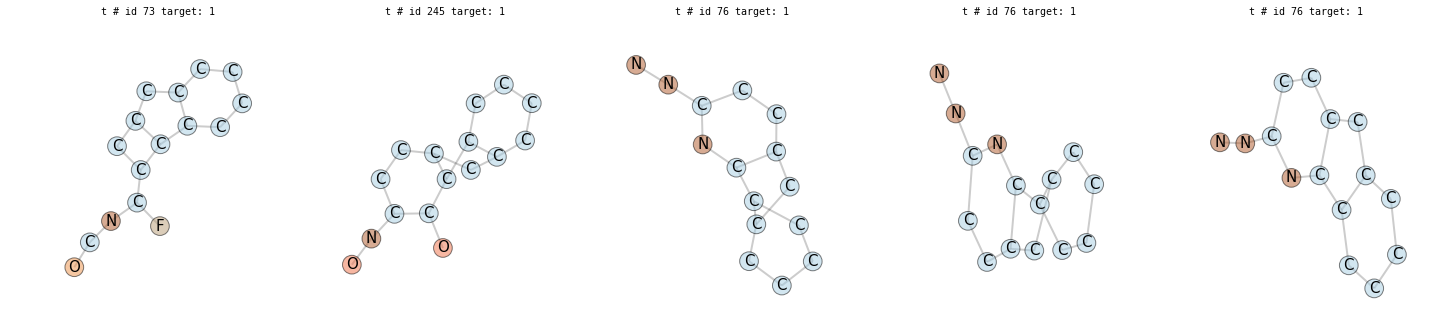

Graph id: 53


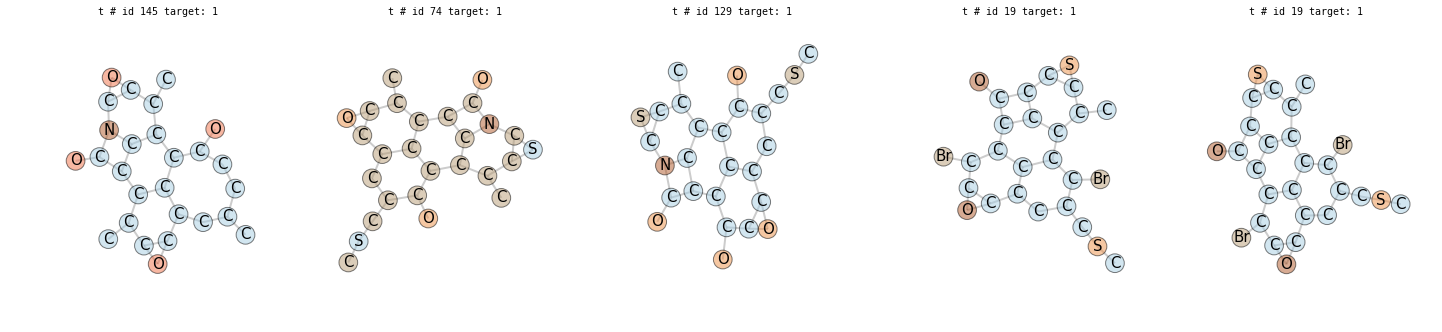

Graph id: 54


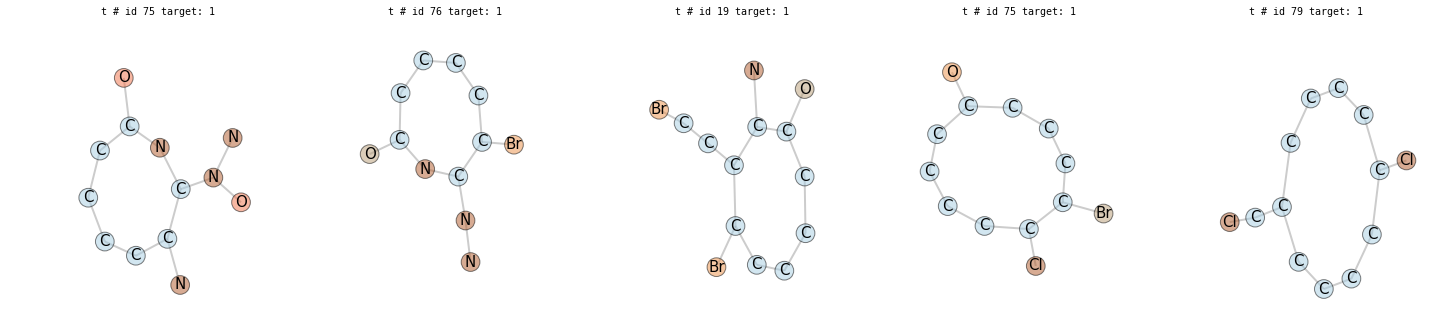

Graph id: 55


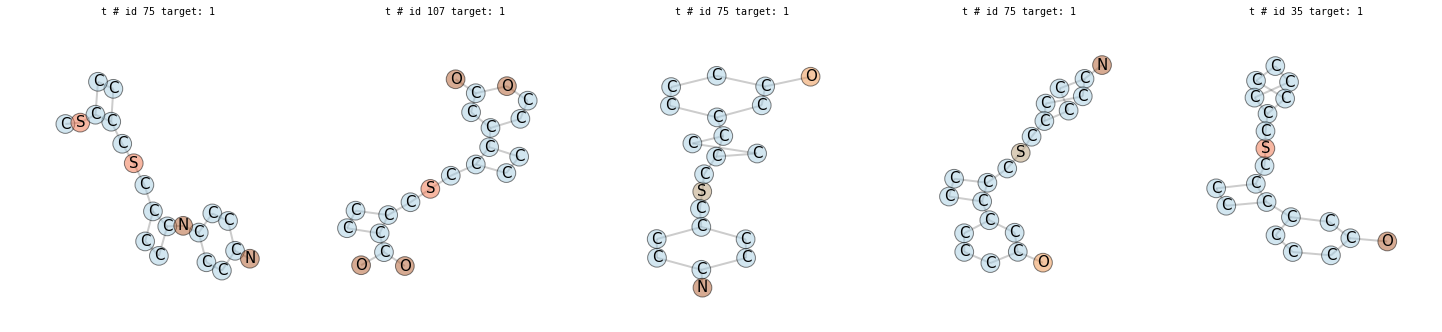

CPU times: user 7.48 s, sys: 248 ms, total: 7.73 s
Wall time: 8.31 s


In [6]:
%%time
BABELDRAW=False
# for each graphlist that is yielded by the sampler:
scores=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    
    # collect scores of each graph that appeared during the sampling 
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    
    # choose a drawing method.
    if BABELDRAW:
        # babel draw looks nice, but may lack detail
        from graphlearn.utils import openbabel
        openbabel.draw(graphlist, d3=False, n_graphs_per_line=6,size=200)
    else:
        from graphlearn.utils import draw
        # graphlearns drawing method is offering many options
        draw.graphlearn(graphlist,
                        contract=True,
                        n_graphs_per_line=6, 
                        size=5, 
                        colormap='Paired', 
                        invert_colormap=False,
                        node_border=0.5, 
                        vertex_color='_labels_',
                        vertex_alpha=0.5, 
                        edge_alpha=0.2, 
                        node_size=350)

# Show sample score history

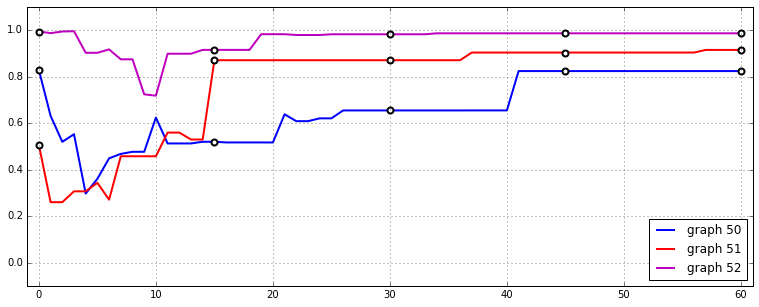

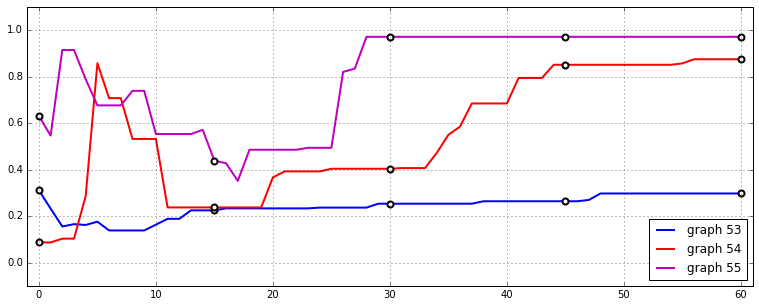

CPU times: user 272 ms, sys: 12 ms, total: 284 ms
Wall time: 282 ms


In [7]:
%%time
from itertools import islice
import numpy as np
import pylab as plt

markevery=n_steps/(n_samples)
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])

for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
     
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()

---